In [1]:
import sys
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
import datetime

from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler

from sklearn.metrics import adjusted_mutual_info_score as ami

from tqdm.notebook import tqdm
import pickle

sys.version

'3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]'

In [2]:
%load_ext autoreload 
%autoreload 2

### Read the data files

In [3]:
df_ticker = pd.read_csv("sp500_ticker_sector.csv")
stock_prices = pd.read_csv("sp500_stock_prices.csv", header=[0, 1], low_memory=False)

In [4]:
close_prices = pd.read_csv("sp500_close_prices.csv",index_col=0)
close_prices.index = pd.to_datetime(close_prices.index)

In [5]:
close_prices.head()

A        AAL       AAPL       ABBV        ABT       ACGL  \
Date                                                                           
2018-01-02  64.734840  51.647560  40.776527  74.990417  53.086952  29.433332   
2018-01-03  66.381973  51.014027  40.769424  76.163887  53.204350  29.459999   
2018-01-04  65.884003  51.335667  40.958805  75.729546  53.114044  29.570000   
2018-01-05  66.937386  51.316170  41.425129  77.047852  53.267559  29.453333   
2018-01-08  67.081039  50.809345  41.271259  75.813385  53.114044  29.456667   

                   ACN        ADBE        ADI        ADM  ...        WYNN  \
Date                                                      ...               
2018-01-02  140.888611  177.699997  80.850540  34.276730  ...  153.976532   
2018-01-03  141.538879  181.039993  81.853554  34.011681  ...  152.308350   
2018-01-04  143.214783  183.220001  81.764000  34.584526  ...  153.133041   
2018-01-05  144.396194  185.339996  82.095352  34.353672  ...  154.154556   
2018-01-08  145.550125  185.039993  82.238655  34.276730  ...  152.102173   

                  XEL        XOM       XRAY        XYL        YUM         ZBH  \
Date                                                                            
2018-01-02  40.473232  63.798702  63.374939  63.492680  73.644981  115.217323   
2018-01-03  40.202328  65.051720  63.157841  64.266853  73.581810  116.016029   
2018-01-04  39.889103  65.141762  63.148384  64.695938  74.330910  115.848862   
2018-01-05  39.609749  65.089241  64.035667  64.574669  74.764091  117.000481   
2018-01-08  39.906036  65.381844  64.469910  64.807846  74.890465  117.223373   

                  ZBRA       ZION        ZTS  
Date                                          
2018-01-02  103.709999  42.626457  69.128296  
2018-01-03  105.769997  42.576012  69.446159  
2018-01-04  107.860001  42.752579  69.860329  
2018-01-05  109.540001  42.769394  70.659790  
2018-01-08  110.629997  42.559204  71.507401  

[5 rows x 476 columns]

### Plot all the sectors

In [6]:
df_ticker["GICS Sector"].value_counts()

Industrials               77
Financials                72
Health Care               64
Information Technology    64
Consumer Discretionary    53
Consumer Staples          38
Real Estate               31
Utilities                 30
Materials                 29
Energy                    23
Communication Services    22
Name: GICS Sector, dtype: int64

In [7]:
#we have 479 time series
X_train = TimeSeriesScalerMeanVariance().fit_transform(close_prices.T)
X_train.shape

(476, 1237, 1)

In [8]:
get_sector = lambda x: df_ticker[df_ticker.Symbol==x]["GICS Sector"].values[0]

In [9]:
y_train = np.array([get_sector(tick) for tick in close_prices.columns])
y_train.shape

(476,)

In [10]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [12, 5]

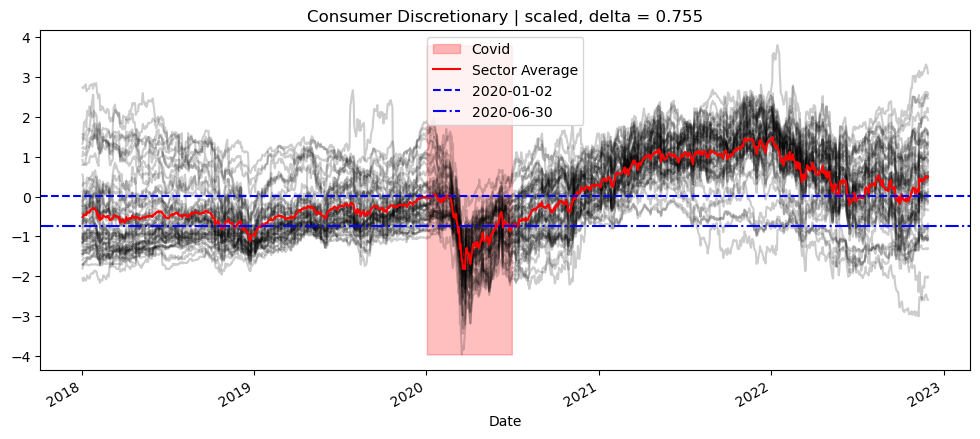

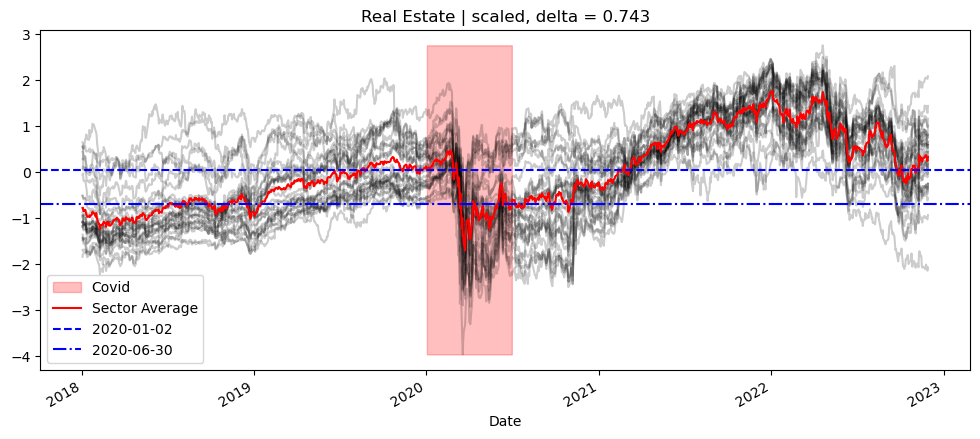

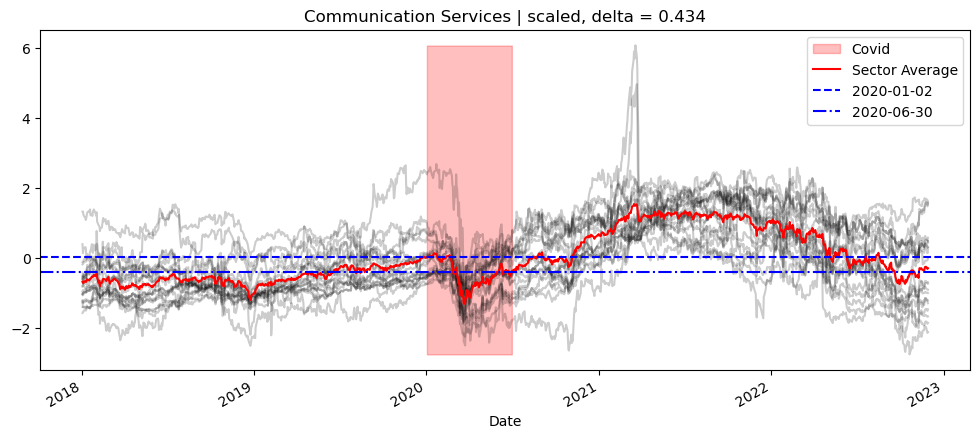

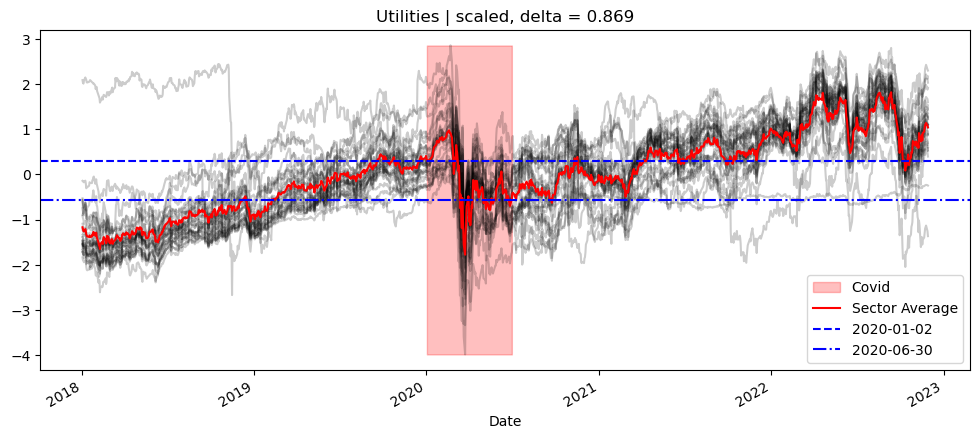

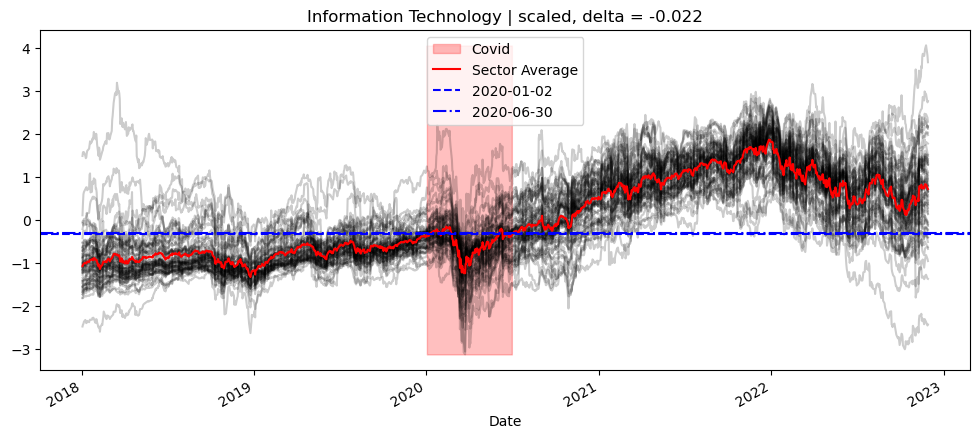

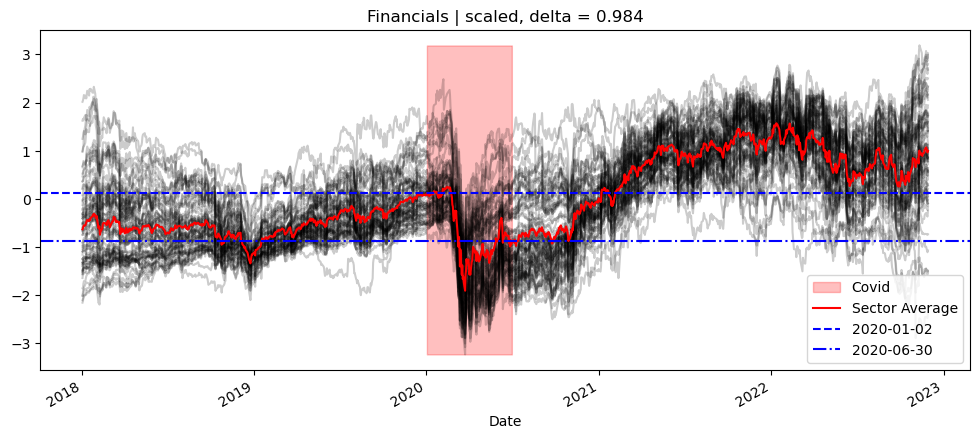

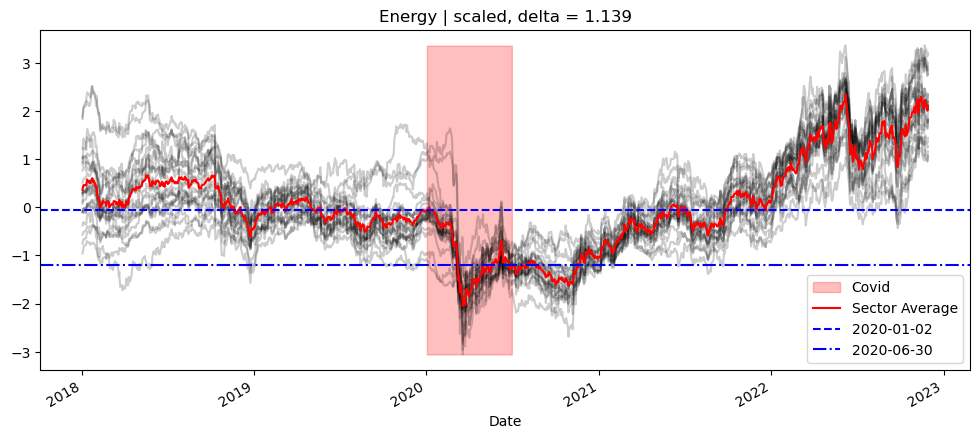

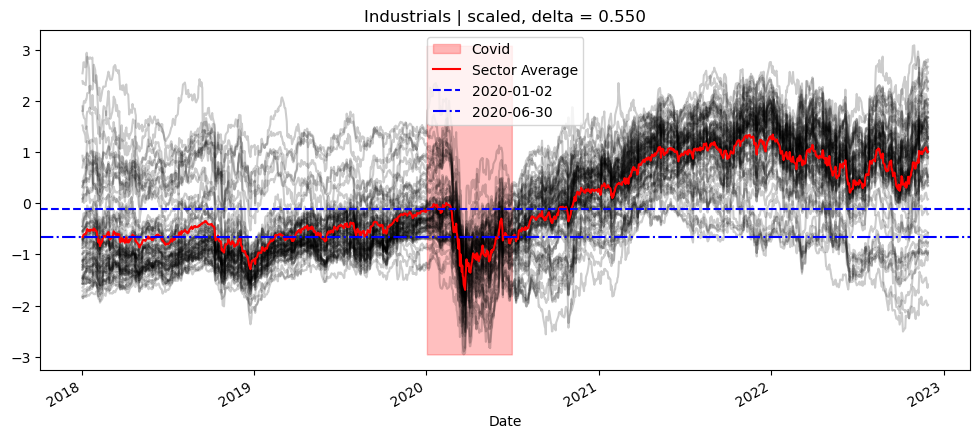

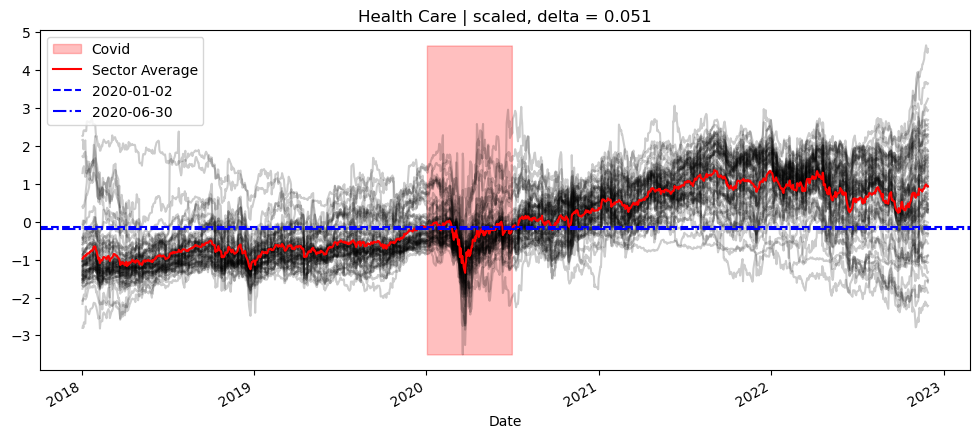

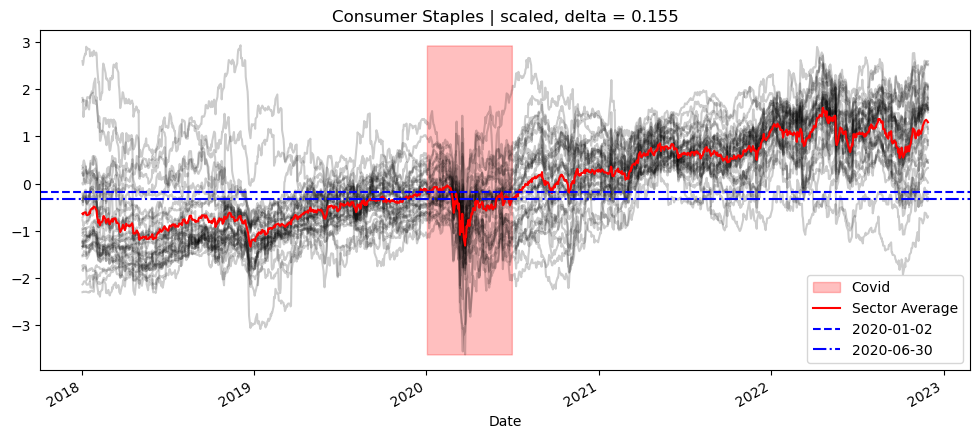

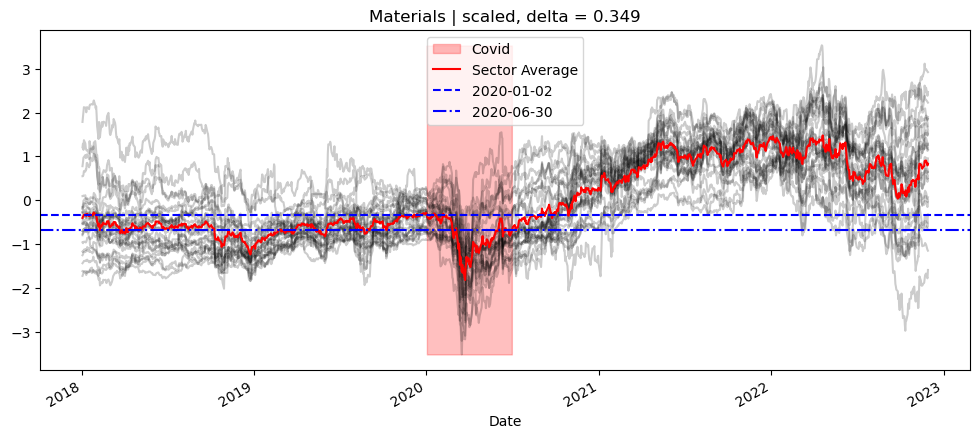

In [11]:
for sector in set(y_train):
    stocks_with_sector = y_train==sector
    df_subset = close_prices.loc[:,stocks_with_sector]
    sector_cols = df_subset.columns
    scaled_subset = pd.DataFrame(X_train[stocks_with_sector,:,0].T, columns = sector_cols)
    scaled_subset.index = df_subset.index
    val_at_id1 = scaled_subset.mean(axis=1)["2020-01-02"]
    val_at_id2 = scaled_subset.mean(axis=1)["2020-06-30"]
    delta = val_at_id1-val_at_id2
    scaled_subset.plot(title =f"{sector} | scaled, delta = {delta:.3f}", alpha = 0.2, c= "black", legend= False)
    id1 = list(close_prices.index).index(pd.to_datetime("2020-01-02"))
    
    # Plotting Graph
    area_fill = plt.fill_betweenx(np.arange(scaled_subset.min().min(), scaled_subset.max().max(), 0.01), pd.to_datetime("2020-01-02"),pd.to_datetime("2020-06-30"), color="red",alpha=0.25, label = "Covid")
    avg = scaled_subset.mean(axis=1)
    line_a = plt.plot(avg.index, avg, color ="red", label = "Sector Average")
    line2 = plt.axhline(y=val_at_id1, label = "2020-01-02", color = "blue", linestyle = "dashed")
    line3 = plt.axhline(y=val_at_id2, label = "2020-06-30", color = "blue", linestyle = "-.")
    plt.legend([area_fill,line_a[0],line2,line3],["Covid","Sector Average","2020-01-02","2020-06-30"])

### Analyse the clusters

In [12]:
with open('result_dict.pickle', 'rb') as f:
    result_dic = pickle.load(f)

result_df = pd.DataFrame.from_dict(result_dic, orient="index")
result_df.columns = ["model", "y_pred", "ami"]
result_df.head()

model  \
5  TimeSeriesKMeans(max_iter_barycenter=10, metri...   
6  TimeSeriesKMeans(max_iter_barycenter=10, metri...   
7  TimeSeriesKMeans(max_iter_barycenter=10, metri...   
8  TimeSeriesKMeans(max_iter_barycenter=10, metri...   
9  TimeSeriesKMeans(max_iter_barycenter=10, metri...   

                                              y_pred       ami  
5  [2, 4, 2, 2, 0, 0, 2, 3, 2, 2, 2, 0, 2, 2, 2, ...  0.069633  
6  [0, 5, 0, 0, 4, 4, 0, 3, 0, 0, 0, 4, 0, 2, 3, ...  0.105111  
7  [2, 0, 1, 2, 3, 2, 1, 4, 2, 1, 1, 2, 1, 1, 1, ...  0.075426  
8  [0, 1, 5, 0, 4, 4, 0, 7, 0, 5, 0, 4, 0, 5, 7, ...  0.104306  
9  [7, 6, 1, 7, 2, 2, 5, 1, 7, 5, 7, 7, 1, 4, 1, ...  0.098642

In [13]:
result_df["inertia"] = result_df["model"].apply(lambda x: x.inertia_)

In [14]:
np.unique(result_df["y_pred"][8])

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64)

In [15]:
np.unique(result_df["model"][8].labels_)

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64)

In [16]:
result_df[["ami","inertia"]].style.highlight_max(color = 'lightgreen', axis = 0,subset=["ami"]).highlight_min(color = 'lightgreen', axis = 0,subset=["inertia"])

### Elbow Plot

<AxesSubplot:>

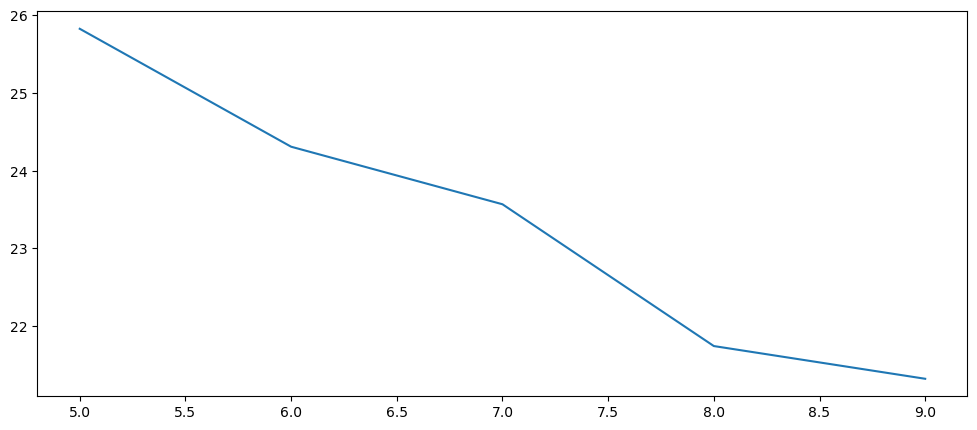

In [17]:
result_df["inertia_lag1"] = result_df["inertia"].shift(1)
result_df["delta_interia"] = result_df["inertia_lag1"]-result_df["inertia"]

fig, ax = plt.subplots() 
result_df["inertia"].plot(ax = ax) 

In [18]:
result_df

model  \
5  TimeSeriesKMeans(max_iter_barycenter=10, metri...   
6  TimeSeriesKMeans(max_iter_barycenter=10, metri...   
7  TimeSeriesKMeans(max_iter_barycenter=10, metri...   
8  TimeSeriesKMeans(max_iter_barycenter=10, metri...   
9  TimeSeriesKMeans(max_iter_barycenter=10, metri...   

                                              y_pred       ami    inertia  \
5  [2, 4, 2, 2, 0, 0, 2, 3, 2, 2, 2, 0, 2, 2, 2, ...  0.069633  25.824961   
6  [0, 5, 0, 0, 4, 4, 0, 3, 0, 0, 0, 4, 0, 2, 3, ...  0.105111  24.308446   
7  [2, 0, 1, 2, 3, 2, 1, 4, 2, 1, 1, 2, 1, 1, 1, ...  0.075426  23.568359   
8  [0, 1, 5, 0, 4, 4, 0, 7, 0, 5, 0, 4, 0, 5, 7, ...  0.104306  21.744971   
9  [7, 6, 1, 7, 2, 2, 5, 1, 7, 5, 7, 7, 1, 4, 1, ...  0.098642  21.324224   

   inertia_lag1  delta_interia  
5           NaN            NaN  
6     25.824961       1.516515  
7     24.308446       0.740087  
8     23.568359       1.823388  
9     21.744971       0.420747

### Cross tab

In [19]:
result_df.loc[8]["model"]

TimeSeriesKMeans(max_iter_barycenter=10, metric='dtw', n_clusters=8, n_init=2,
                 n_jobs=-1, random_state=77, tol=0.01, verbose=True)

In [20]:
get_sub_sector = lambda x: df_ticker[df_ticker.Symbol==x]["GICS Sub-Industry"].values[0]

In [21]:
y_pred1 = result_df.loc[8]["y_pred"][:476]
cross = pd.DataFrame()
cross["stocks"] = close_prices.columns
cross["sector"] = y_train
cross["sub_sector"] = np.array([get_sub_sector(tick) for tick in close_prices.columns])
cross["predicted_label"] = y_pred1

In [22]:
cross["predicted_label"].value_counts()

0    151
4     71
5     63
7     58
6     45
2     38
1     34
3     16
Name: predicted_label, dtype: int64

In [23]:
cross["sub_sector"].value_counts()

Health Care Equipment    19
Semiconductors           15
Application Software     13
Electric Utilities       13
Multi-Utilities          12
                         ..
Leisure Products          1
Hotel & Resort REITs      1
Industrial Machinery      1
Food Retail               1
Timber REITs              1
Name: sub_sector, Length: 123, dtype: int64

In [24]:
res1 = pd.crosstab(cross.sector, cross.predicted_label, margins=True, margins_name="Total")
res2 = pd.crosstab(cross.sub_sector, cross.predicted_label, margins=True, margins_name="Total")

In [25]:
writer = pd.ExcelWriter("crosstab.xlsx", engine='xlsxwriter')
# Write each dataframe to a different worksheet.
res1.to_excel(writer, sheet_name='Sector')
res2.to_excel(writer, sheet_name='Sub_sector')
# Close the Pandas Excel writer and output the Excel file.
writer.close()

In [26]:
res1.style.highlight_max(color = 'lightgreen', axis = 1).highlight_max(color = 'lightgreen', axis = 0)

In [27]:
res2.style.highlight_max(color = 'lightgreen', axis = 1).highlight_max(color = 'lightgreen', axis = 0)

### Plot Clusters

In [28]:
matplotlib.rcParams['figure.figsize'] = [12, 8]

### Cluster Avg plot

In [29]:
all_cluster_avg = pd.DataFrame()
for cluster in set(y_pred1):
    stocks_with_cluster = y_pred1==cluster
    df_subset = close_prices.loc[:,stocks_with_cluster]
    sector_cols = df_subset.columns
    scaled_subset = pd.DataFrame(X_train[stocks_with_cluster,:,0].T, columns = sector_cols)
    scaled_subset.index = df_subset.index
    all_cluster_avg[f"Cluster_{cluster}"] = scaled_subset.mean(axis=1)

<AxesSubplot:title={'center':'Average of all clsuters'}, xlabel='Date'>

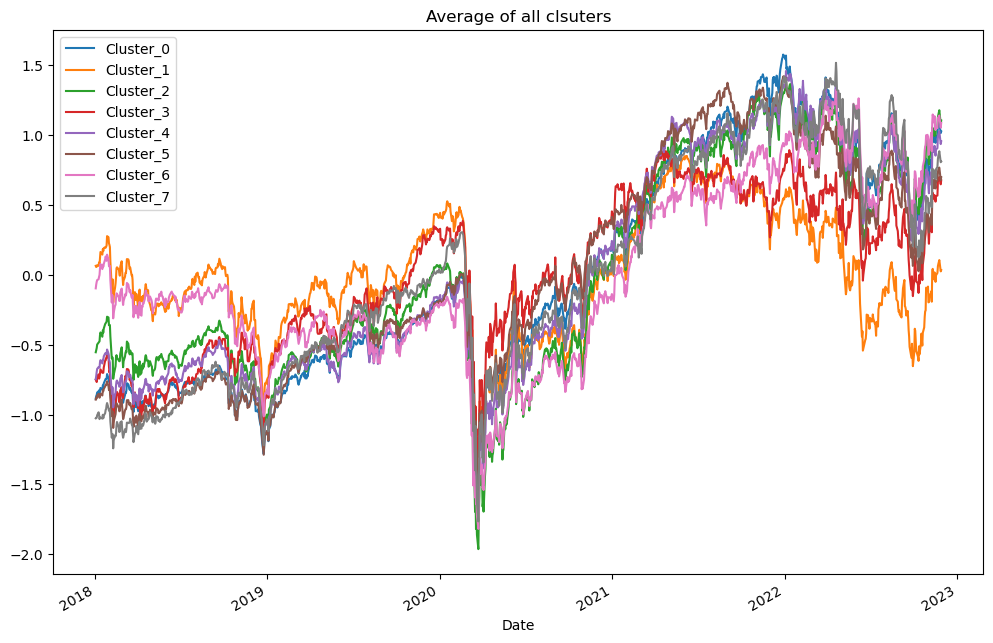

In [30]:
all_cluster_avg.plot(title = "Average of all clsuters")

### Cluster plot

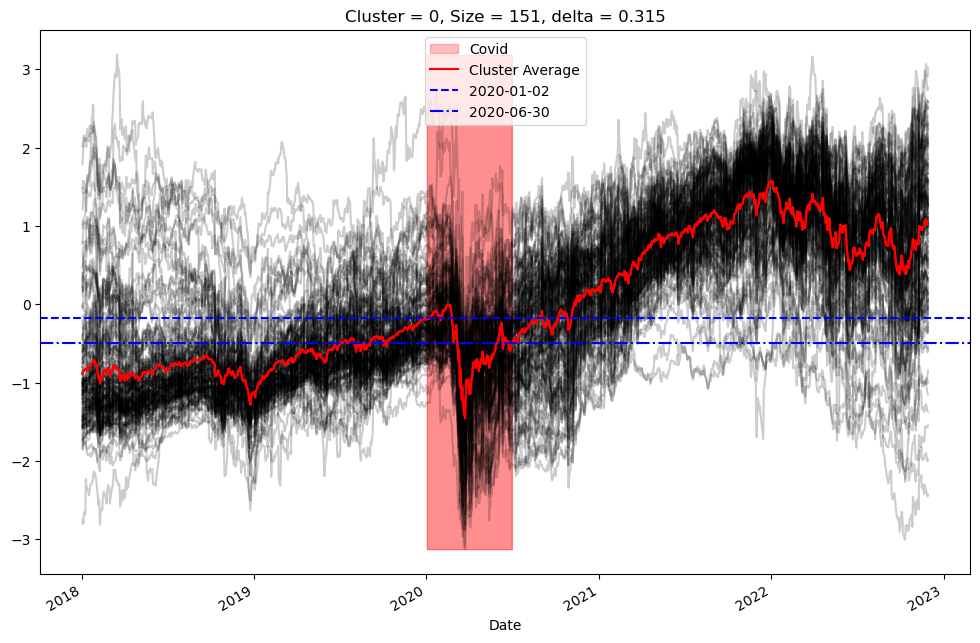

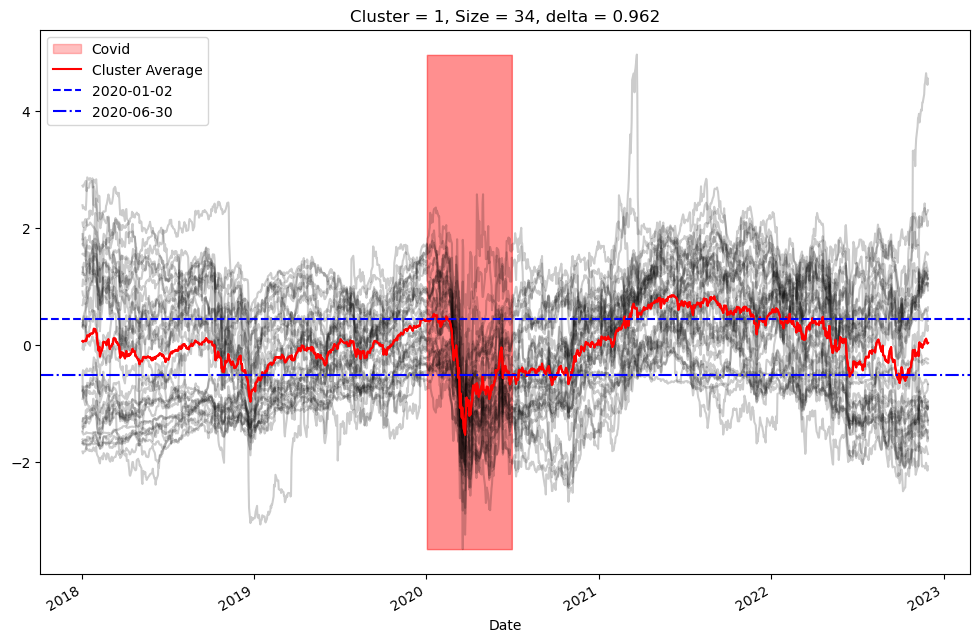

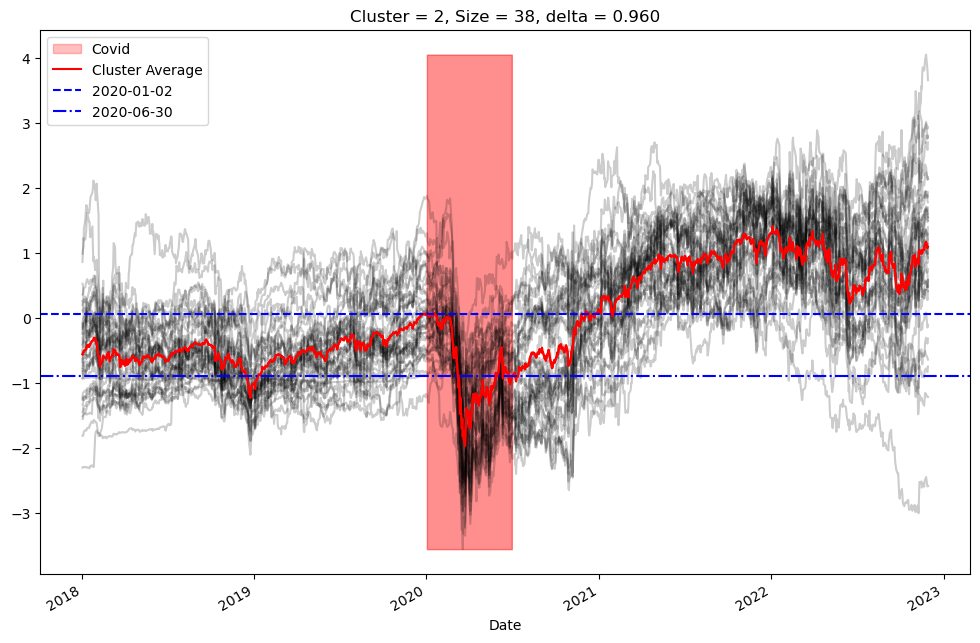

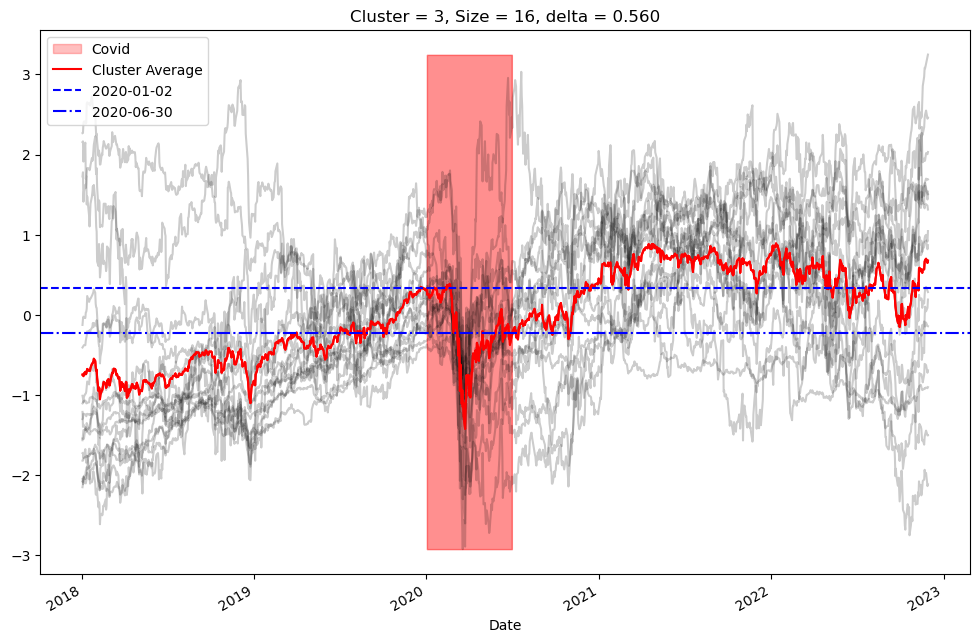

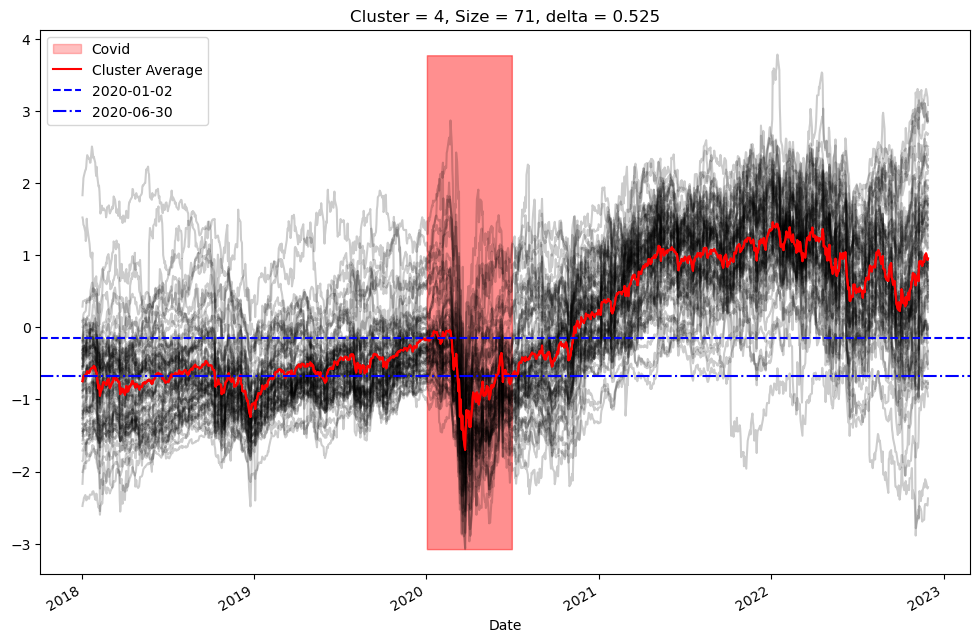

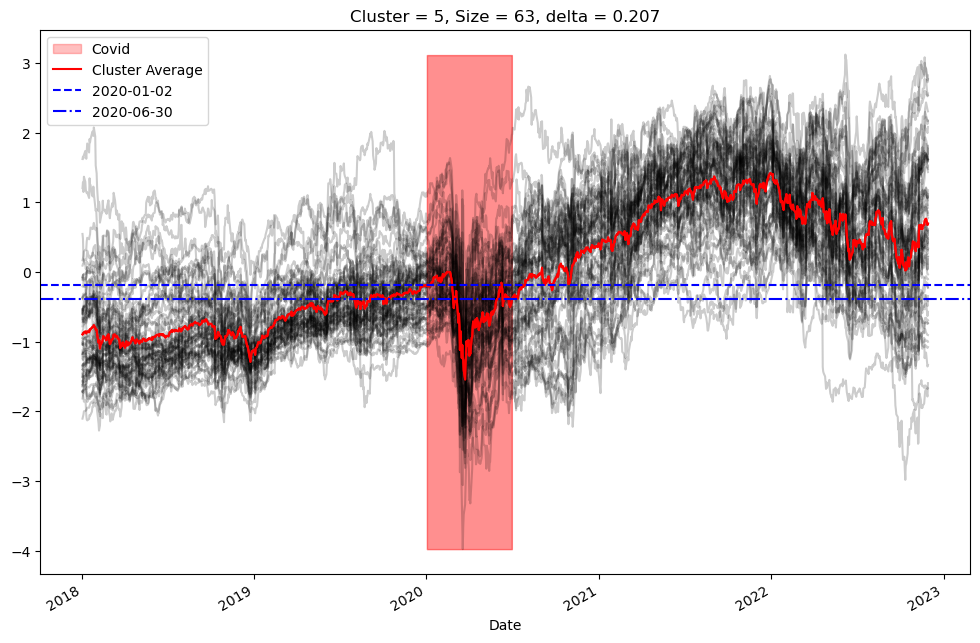

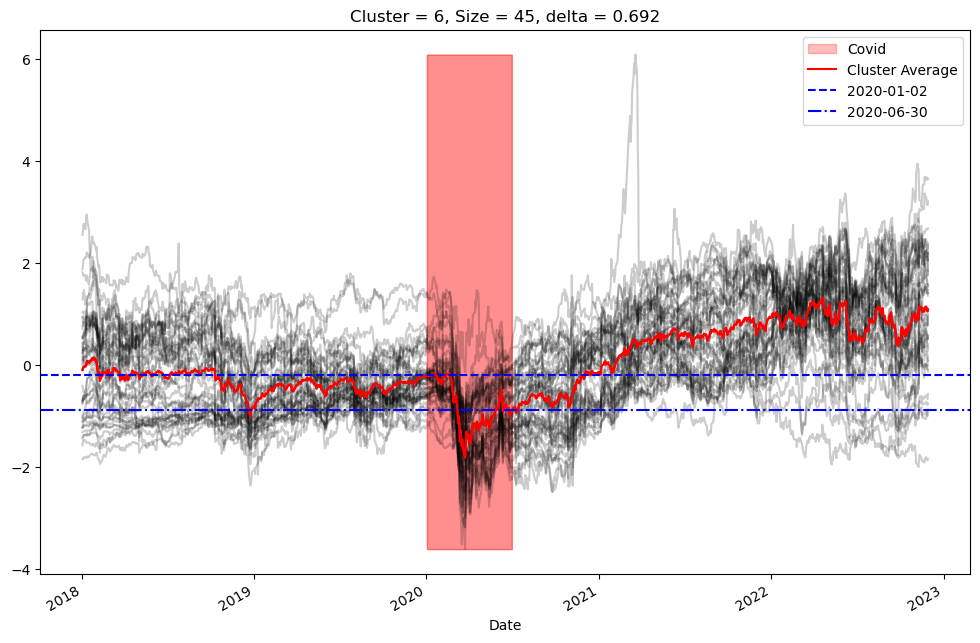

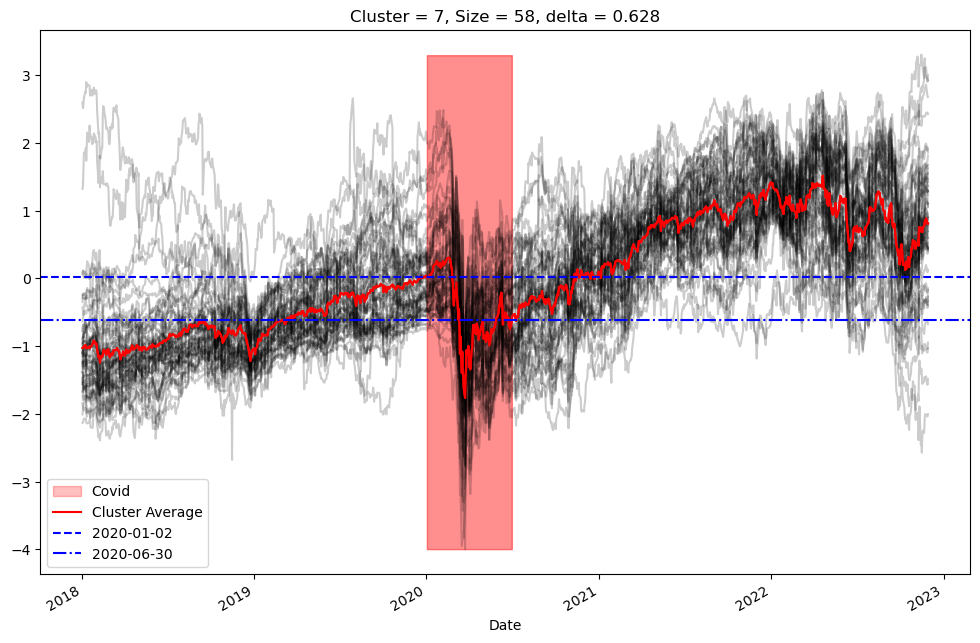

In [31]:
for cluster in set(y_pred1):
    stocks_with_cluster = y_pred1==cluster
    df_subset = close_prices.loc[:,stocks_with_cluster]
    sector_cols = df_subset.columns
    scaled_subset = pd.DataFrame(X_train[stocks_with_cluster,:,0].T, columns = sector_cols)
    scaled_subset.index = df_subset.index
    n_cluster = stocks_with_cluster.sum()
    val_at_id1 = scaled_subset.mean(axis=1)["2020-01-02"]
    val_at_id2 = scaled_subset.mean(axis=1)["2020-06-30"]
    delta = val_at_id1-val_at_id2
    
    # For plotting
    scaled_subset.plot(title =f"Cluster = {cluster}, Size = {n_cluster}, delta = {delta:.3f}", alpha = 0.2, legend = False, c= "black")
    plt.fill_betweenx(np.arange(scaled_subset.min().min(), scaled_subset.max().max(), 0.01), pd.to_datetime("2020-01-02"),pd.to_datetime("2020-06-30"), color="red",alpha=0.25, label = "Covid")
    scaled_subset.mean(axis=1).plot(color="red")
    area_fill = plt.fill_betweenx(np.arange(scaled_subset.min().min(), scaled_subset.max().max(), 0.01), pd.to_datetime("2020-01-02"),pd.to_datetime("2020-06-30"), color="red",alpha=0.25, label = "Covid")
    avg = scaled_subset.mean(axis=1)
    line_a = plt.plot(avg.index, avg, color ="red", label = "Cluster Average")
    line2 = plt.axhline(y=val_at_id1, label = "2020-01-02", color = "blue", linestyle = "dashed")
    line3 = plt.axhline(y=val_at_id2, label = "2020-06-30", color = "blue", linestyle = "-.")
    plt.legend([area_fill,line_a[0],line2,line3],["Covid","Cluster Average","2020-01-02","2020-06-30"])
    # plt.savefig(f"../../plots/cluster_{cluster}_plot.jpeg")
    

# Deep Analysis

In [33]:
cluster_5_stocks = cross.predicted_label == 5
IT_stocks = cross.sector == "Information Technology"
final_mask = cluster_5_stocks & IT_stocks
cross.loc[final_mask]

# only 8 stocks from 62 stocks in IT sector 

stocks                  sector  \
2     AAPL  Information Technology   
33    ANET  Information Technology   
111   CSCO  Information Technology   
154   EPAM  Information Technology   
362    PTC  Information Technology   
366   QRVO  Information Technology   
377    ROP  Information Technology   
473   ZBRA  Information Technology   

                                     sub_sector  predicted_label  
2    Technology Hardware, Storage & Peripherals                5  
33                     Communications Equipment                5  
111                    Communications Equipment                5  
154              IT Consulting & Other Services                5  
362                        Application Software                5  
366                              Semiconductors                5  
377          Electronic Equipment & Instruments                5  
473          Electronic Equipment & Instruments                5

In [37]:
IT_stocks2 = cross.sector == "Information Technology"
final_mask2 = IT_stocks2
cross.loc[final_mask2]

stocks                  sector  \
2     AAPL  Information Technology   
6      ACN  Information Technology   
7     ADBE  Information Technology   
8      ADI  Information Technology   
11    ADSK  Information Technology   
..     ...                     ...   
428    TXN  Information Technology   
430    TYL  Information Technology   
445   VRSN  Information Technology   
454    WDC  Information Technology   
473   ZBRA  Information Technology   

                                     sub_sector  predicted_label  
2    Technology Hardware, Storage & Peripherals                5  
6                IT Consulting & Other Services                0  
7                          Application Software                7  
8                                Semiconductors                0  
11                         Application Software                4  
..                                          ...              ...  
428                              Semiconductors                0  
430                        Application Software                0  
445          Internet Services & Infrastructure                4  
454  Technology Hardware, Storage & Peripherals                0  
473          Electronic Equipment & Instruments                5  

[62 rows x 4 columns]